In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
%matplotlib inline

from bin_time_mz import bin_time

In [2]:
import tensorflow as tf
from tensorflow.keras import *

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  8


# Load Data and process MS1 features

In [4]:
table = {}

for i in glob.glob("ms1_training/*"):
    
    df = pd.read_csv(i, index_col=0)
    binned = bin_time(df, rt_window=1, mz_window=1.0005079)
    table[i.replace("ms1_training/","").replace("_ms1.csv", "")] = binned
    

In [5]:
for i in glob.glob("ms1_external/*"):
    
    df = pd.read_csv(i, index_col=0)
    binned = bin_time(df, rt_window=1, mz_window=1.0005079)
    table[i.replace("ms1_external/","").replace("_ms1.csv", "")] = binned
    

In [6]:
df = pd.DataFrame(table).transpose()
df = df.apply(lambda x: x/x.max(), axis=1)
df

,0,1,2,3,4,5,6,7,8,9,...,1790,1791,1792,1793,1794,1795,1796,1797,1798,1799
PXD016880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000
PXD007585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000
PXD016519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000
PXD002601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000
PXD009207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PXD015392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000294,0.0,0.0,0.000159,0.00072
PXD012798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000
PXD029420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000
PXD009443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000


In [7]:
del(table)

# Setup Training Data

In [8]:
pairs = pd.read_csv("train_pairs.txt")
pairs

,PID1,PID2,Jaccard_Index
0,PXD002434,PXD012611,0.000000
1,PXD018291,PXD014062,0.000000
2,PXD006539,PXD000050,0.000000
3,PXD018291,PXD002552,0.000000
4,PXD006539,PXD011152,0.000000
...,...,...,...
404545,PXD002087,PXD005353,0.497725
404546,PXD002212,PXD002211,0.514724
404547,PXD002081,PXD002046,0.531152
404548,PXD002081,PXD002085,0.542056


In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(pairs, test_size=0.2, random_state=42)

In [10]:
score = train['Jaccard_Index'].values
score

array([0.00465116, 0.        , 0.00389105, ..., 0.00345871, 0.0042735 ,
       0.00297619])

In [11]:
training_set = []

for index, row in train.iterrows():
    
#    if (row['PID1'] in df.index) and (row['PID2'] in df.index):
    
    testing = np.vstack(( np.array(df.loc[row['PID1']]), np.array(df.loc[row['PID2']])))
    
    training_set.append(testing)

In [12]:
training_set = np.array(training_set)

# Setup External Test Data

In [13]:
test2 = pd.read_csv("test_pairs.txt")
test2

,PID1,PID2,Jaccard_Index
0,PXD005184,PXD016001,0.000000
1,PXD005184,PXD002548,0.000000
2,PXD018048,PXD017336,0.000000
3,PXD003105,PXD002548,0.000000
4,PXD016680,PXD017336,0.000000
...,...,...,...
2140,PXD007864,PXD016001,0.203302
2141,PXD015369,PXD006332,0.209389
2142,PXD009687,PXD006332,0.228904
2143,PXD029420,PXD025626,0.232863


In [14]:
testing_set2 = []

for index, row in test2.iterrows():
    
#    if (row['PID1'] in df.index) and (row['PID2'] in df.index):
    
    testing = np.vstack(( np.array(df.loc[row['PID1']]), np.array(df.loc[row['PID2']] )))
    
    testing_set2.append(testing)

In [15]:
testing_set2 = np.array(testing_set2)
testing_score2 = test2['Jaccard_Index']

# Training

In [16]:
from tensorflow_addons.optimizers import RectifiedAdam, LazyAdam

/people/shou626/.conda/envs/dl_tf/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [19]:
model = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(64, (2, 6), strides=2, activation='relu', padding='same', input_shape=(2,len(df.columns),1)),
    tf.keras.layers.Conv2D(64, (2, 6), strides=2, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2, padding='same'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(32, (2, 6), strides=2, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32, (2, 6), strides=2, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2, padding='same'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(32, activation='selu',
                         kernel_initializer='lecun_normal',
#                        activity_regularizer=tf.keras.regularizers.l2(0.01))
                        activity_regularizer='l2'), 
    
    tf.keras.layers.Dense(1, activation='sigmoid',
                              kernel_initializer='lecun_normal',
                              activity_regularizer='l2')
                              
])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 1, 900, 64)        832       
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 450, 64)        49216     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 225, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 1, 225, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 1, 113, 32)        24608     
                                                                 
 conv2d_7 (Conv2D)           (None, 1, 57, 32)         12320     
                                                      

In [21]:
#optimization = RectifiedAdam(learning_rate=0.0002)
optimization = RectifiedAdam(learning_rate=0.0002)

model.compile(loss=tf.keras.losses.MeanSquaredError(),
                    optimizer=optimization,
                    metrics=['MAE', 'MSE'])

history = model.fit(training_set, score, epochs=90, batch_size=512,
#                    callbacks=[my_val_callback]
                    validation_data=(testing_set2, testing_score2))

Epoch 1/90


2023-06-19 14:13:44.256569: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2023-06-19 14:13:45.412560: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2023-06-19 14:13:45.637795: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


633/633 [==============================] - 24s 31ms/step - loss: 0.0740 - MAE: 0.1841 - MSE: 0.0510 - val_loss: 0.0371 - val_MAE: 0.1163 - val_MSE: 0.0141
Epoch 2/90
633/633 [==============================] - 19s 30ms/step - loss: 0.0324 - MAE: 0.1017 - MSE: 0.0111 - val_loss: 0.0276 - val_MAE: 0.0995 - val_MSE: 0.0105
Epoch 3/90
633/633 [==============================] - 19s 30ms/step - loss: 0.0243 - MAE: 0.0849 - MSE: 0.0078 - val_loss: 0.0209 - val_MAE: 0.0830 - val_MSE: 0.0074
Epoch 4/90
633/633 [==============================] - 19s 30ms/step - loss: 0.0188 - MAE: 0.0726 - MSE: 0.0058 - val_loss: 0.0164 - val_MAE: 0.0718 - val_MSE: 0.0056
Epoch 5/90
633/633 [==============================] - 19s 30ms/step - loss: 0.0149 - MAE: 0.0633 - MSE: 0.0045 - val_loss: 0.0133 - val_MAE: 0.0663 - val_MSE: 0.0048
Epoch 6/90
633/633 [==============================] - 19s 30ms/step - loss: 0.0121 - MAE: 0.0563 - MSE: 0.0036 - val_loss: 0.0109 - val_MAE: 0.0606 - val_MSE: 0.0041
Epoch 7/90
633/

# Measure Pearson of External set

In [23]:
predicted_external = model.predict(testing_set2)
predicted_external = [i[0] for i in predicted_external]

In [25]:
from scipy import stats

stats.pearsonr(testing_score2, predicted_external)

PearsonRResult(statistic=0.59266772942201, pvalue=1.2603273519438061e-203)

# Save Model

In [26]:
model.save("CNN-FINAL")

2023-06-19 14:43:48.233658: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: CNN-FINAL/assets


In [27]:
model.save('CNN-FINAL.h5')

# Validation

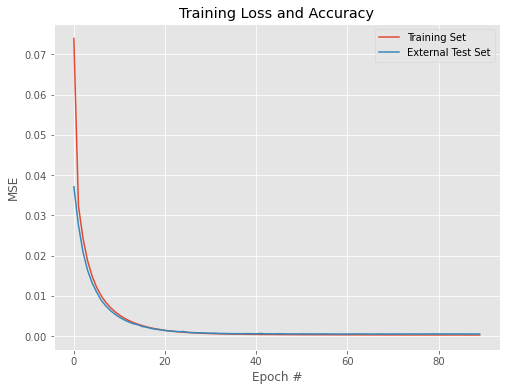

In [28]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# construct a plot that plots and displays the training history
N = np.arange(0, 90)
plt.style.use("ggplot")
plt.figure(figsize=(8,6))
plt.plot(N, history.history["loss"], label="Training Set")
plt.plot(N, history.history["val_loss"], label="External Test Set")
#plt.plot(N, ext_val, label="external_validation")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("MSE")
plt.legend(loc="upper right")
plt.savefig("validation_cnn.png")
plt.show(block=True)

In [29]:
mse = tf.keras.losses.MeanSquaredError()

mse(testing_score2, predicted_external).numpy()

0.00051220716

In [30]:
tf.metrics.MAE(testing_score2, predicted_external).numpy()

0.01508571

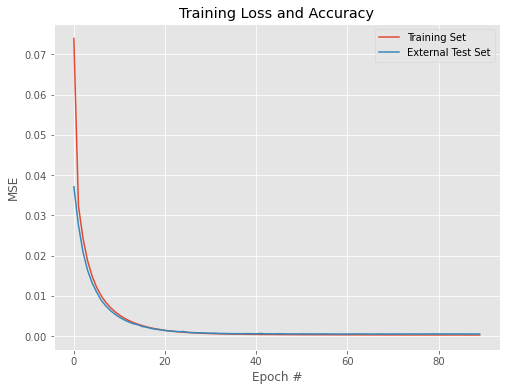

In [31]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# construct a plot that plots and displays the training history
N = np.arange(0, 90)
plt.style.use("ggplot")
plt.figure(figsize=(8,6))
plt.plot(N, history.history["loss"], label="Training Set")
plt.plot(N, history.history["val_loss"], label="External Test Set")
#plt.plot(N, ext_val, label="external_validation")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("MSE")
plt.legend(loc="upper right")
plt.savefig("validation_cnn.png")
plt.show(block=True)

# Predict Training Set

In [32]:
predicted_training = model.predict(training_set)
predicted_training = [i[0] for i in predicted_training]

# Predict for Validation Set

In [33]:
testing_set = []

for index, row in test.iterrows():
    
#    if (row['PID1'] in df.index) and (row['PID2'] in df.index):
    
    testing = np.vstack(( np.array(df.loc[row['PID1']]), np.array(df.loc[row['PID2']])))
    
    testing_set.append(testing)

In [34]:
test_score = test["Jaccard_Index"].values
testing_set = np.array(testing_set)

In [35]:
predicted_testing = model.predict(testing_set)
predicted_testing = [i[0] for i in predicted_testing]

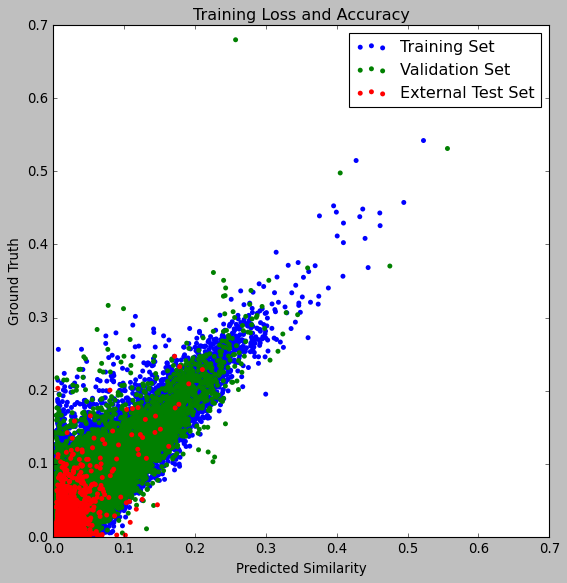

In [36]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# construct a plot that plots and displays the training history
plt.style.use("classic")
plt.figure(figsize=(8,8))
plt.scatter(predicted_training, score, label="Training Set", c='b', edgecolors="None")
plt.scatter(predicted_testing, test_score, label="Validation Set", c='g', edgecolors="None")
plt.scatter(predicted_external, testing_score2, label="External Test Set", c='r', edgecolors="None")
plt.xlim(0,0.7)
plt.ylim(0,0.7)
plt.title("Training Loss and Accuracy")
plt.xlabel("Predicted Similarity")
plt.ylabel("Ground Truth")
plt.legend(loc="upper right")
#plt.savefig("cnn_all.png")
plt.show(block=True)

# Pearson for all

In [37]:
all_predicted = predicted_training + predicted_testing + predicted_external
all_truth = list(score) + list(test_score) + list(testing_score2)

print("pearson", stats.pearsonr(all_predicted, all_truth))

pearson PearsonRResult(statistic=0.9006981753019232, pvalue=0.0)
